In [211]:
import numpy as np
import matplotlib.pyplot as plt
from skinsegmentation import load_skin_segmentation_model,create_skin_mask, refine_mask
import cv2
import math
from math import ceil

In [212]:
model_path = 'model_segmentation_realtime_skin_30.pth'
target_path = 'henderson1.png'
source_path = 'TARGET.jpg'

In [213]:
source_image = cv2.imread(source_path)
target_image = cv2.imread(target_path)



Applying gamma correction

In [214]:
gamma_value = 1.7
 # gamma correction for preprocessing the image to improve the accuracy of the segmentation model 
def apply_gamma_correction(image, gamma):
    # Normalize pixel values to the range [0, 1]
    normalized_image = image / 255.0
    # Apply gamma correction
    corrected_image = np.power(normalized_image, gamma)
    # Scale the values back to [0, 255]
    corrected_image = (corrected_image * 255).astype(np.uint8)
    return corrected_image
 # corrected image is only used by the segmentation but not during the color or style transfer 
corrected_source_image = apply_gamma_correction(source_image, gamma_value)
corrected_target_image = apply_gamma_correction(target_image, gamma_value)

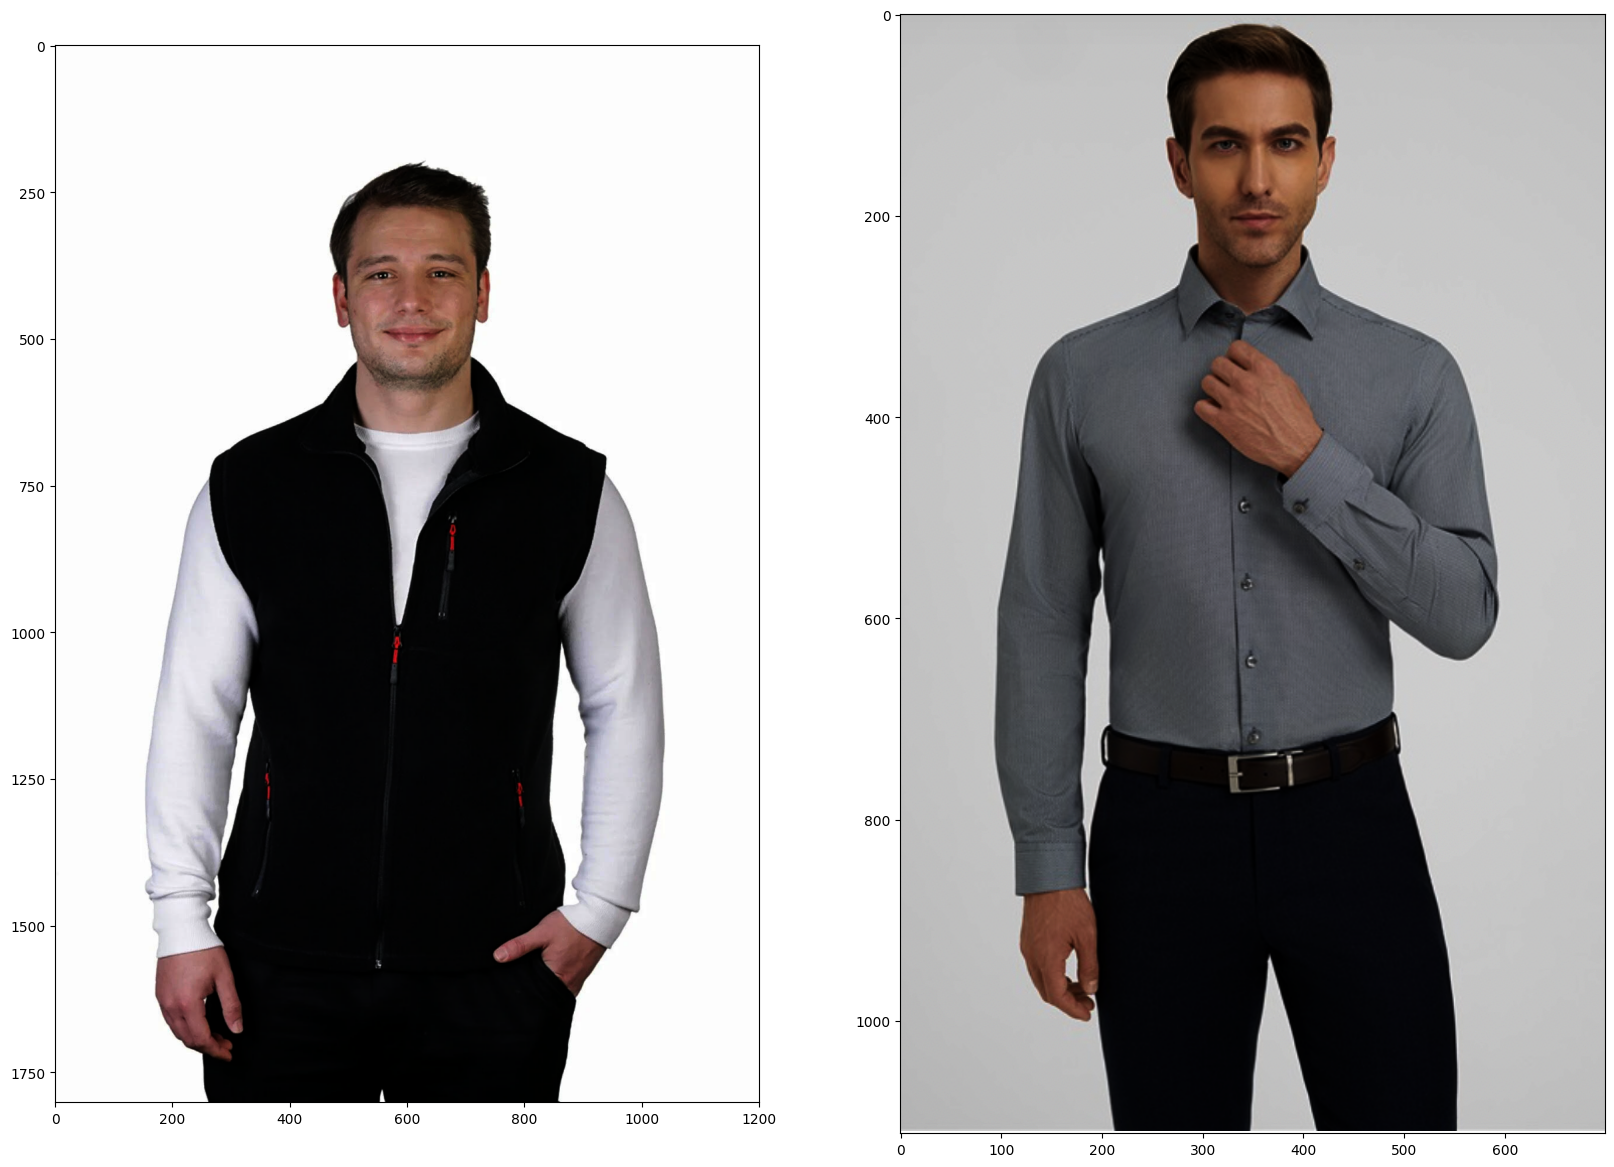

In [215]:
 # plot of the corrected images
f, axarr = plt.subplots(1,2,figsize=(20, 15))
axarr[0].imshow(cv2.cvtColor(corrected_source_image, cv2.COLOR_BGR2RGB))
axarr[1].imshow(cv2.cvtColor(corrected_target_image, cv2.COLOR_BGR2RGB))

In [216]:
model = load_skin_segmentation_model(model_path)
skin_mask_source, resized_source = create_skin_mask(model,corrected_source_image)
skin_mask_target, resized_target = create_skin_mask(model,corrected_target_image)

refined_source_mask = refine_mask(resized_source, model, skin_mask_source)
refined_target_mask = refine_mask(resized_target, model, skin_mask_target)

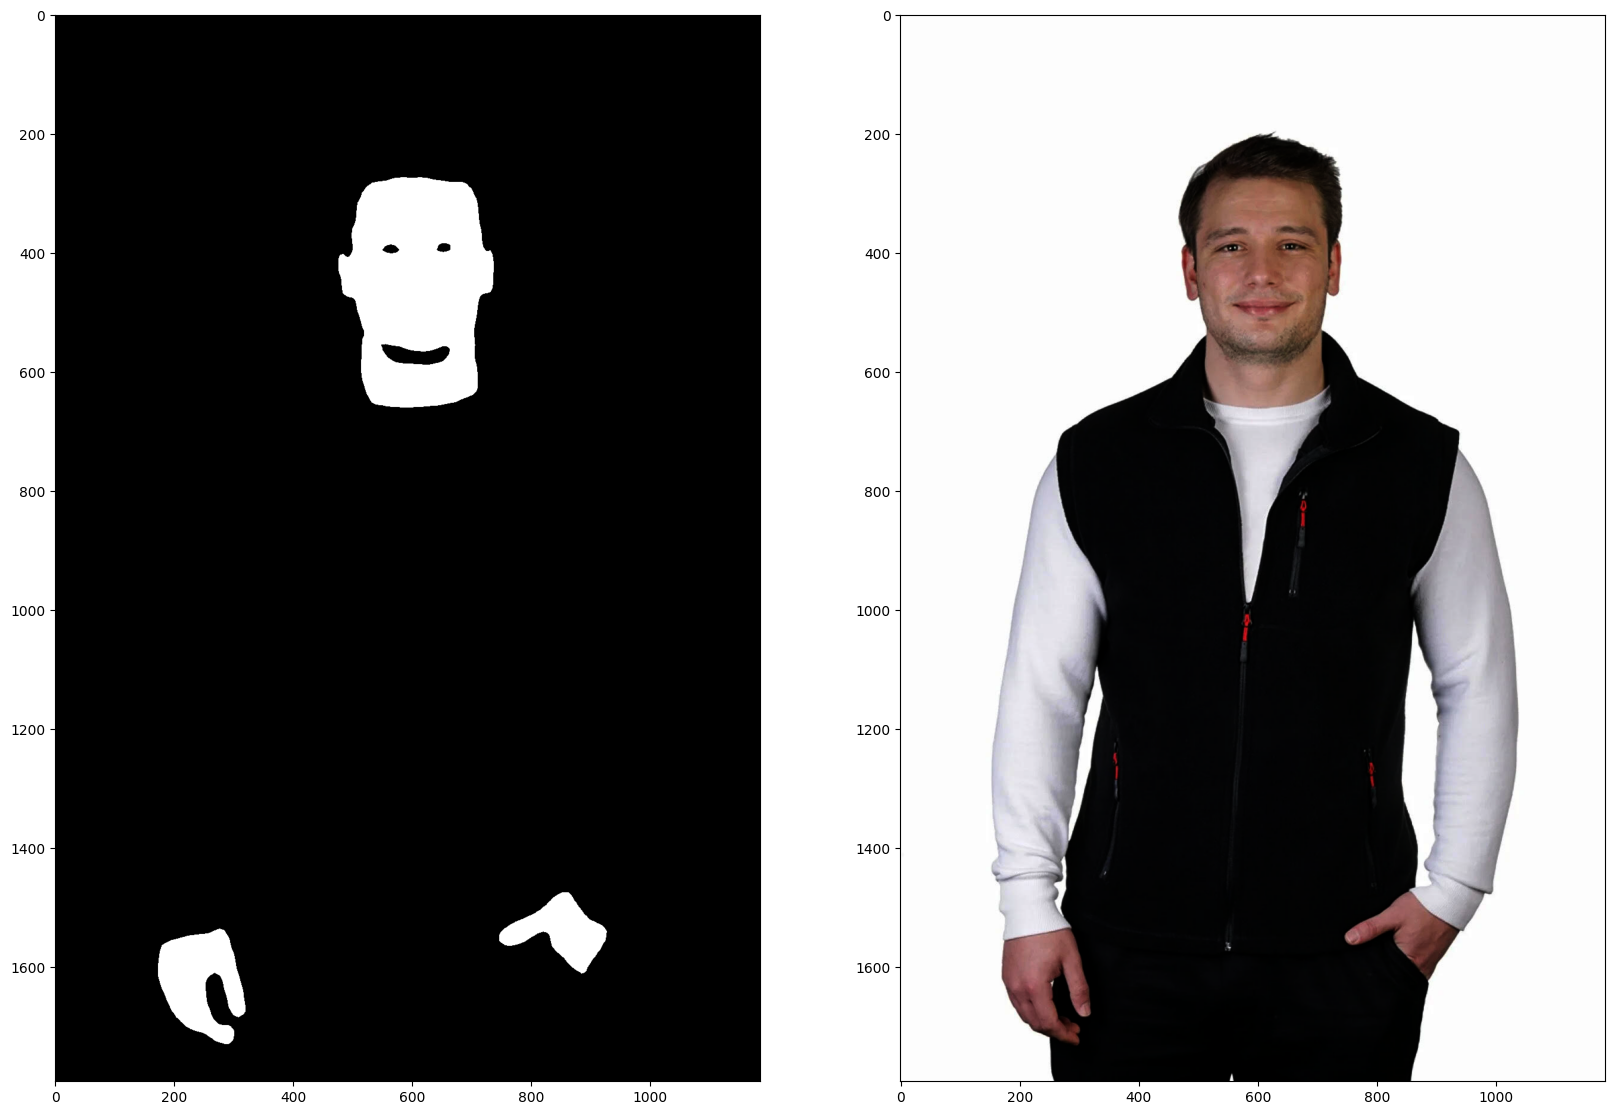

In [217]:
gray = cv2.cvtColor(resized_source, cv2.COLOR_BGR2GRAY)


f, axarr = plt.subplots(1,2,figsize=(20, 15))
axarr[0].imshow(skin_mask_source, cmap='gray')
axarr[1].imshow(resized_source)


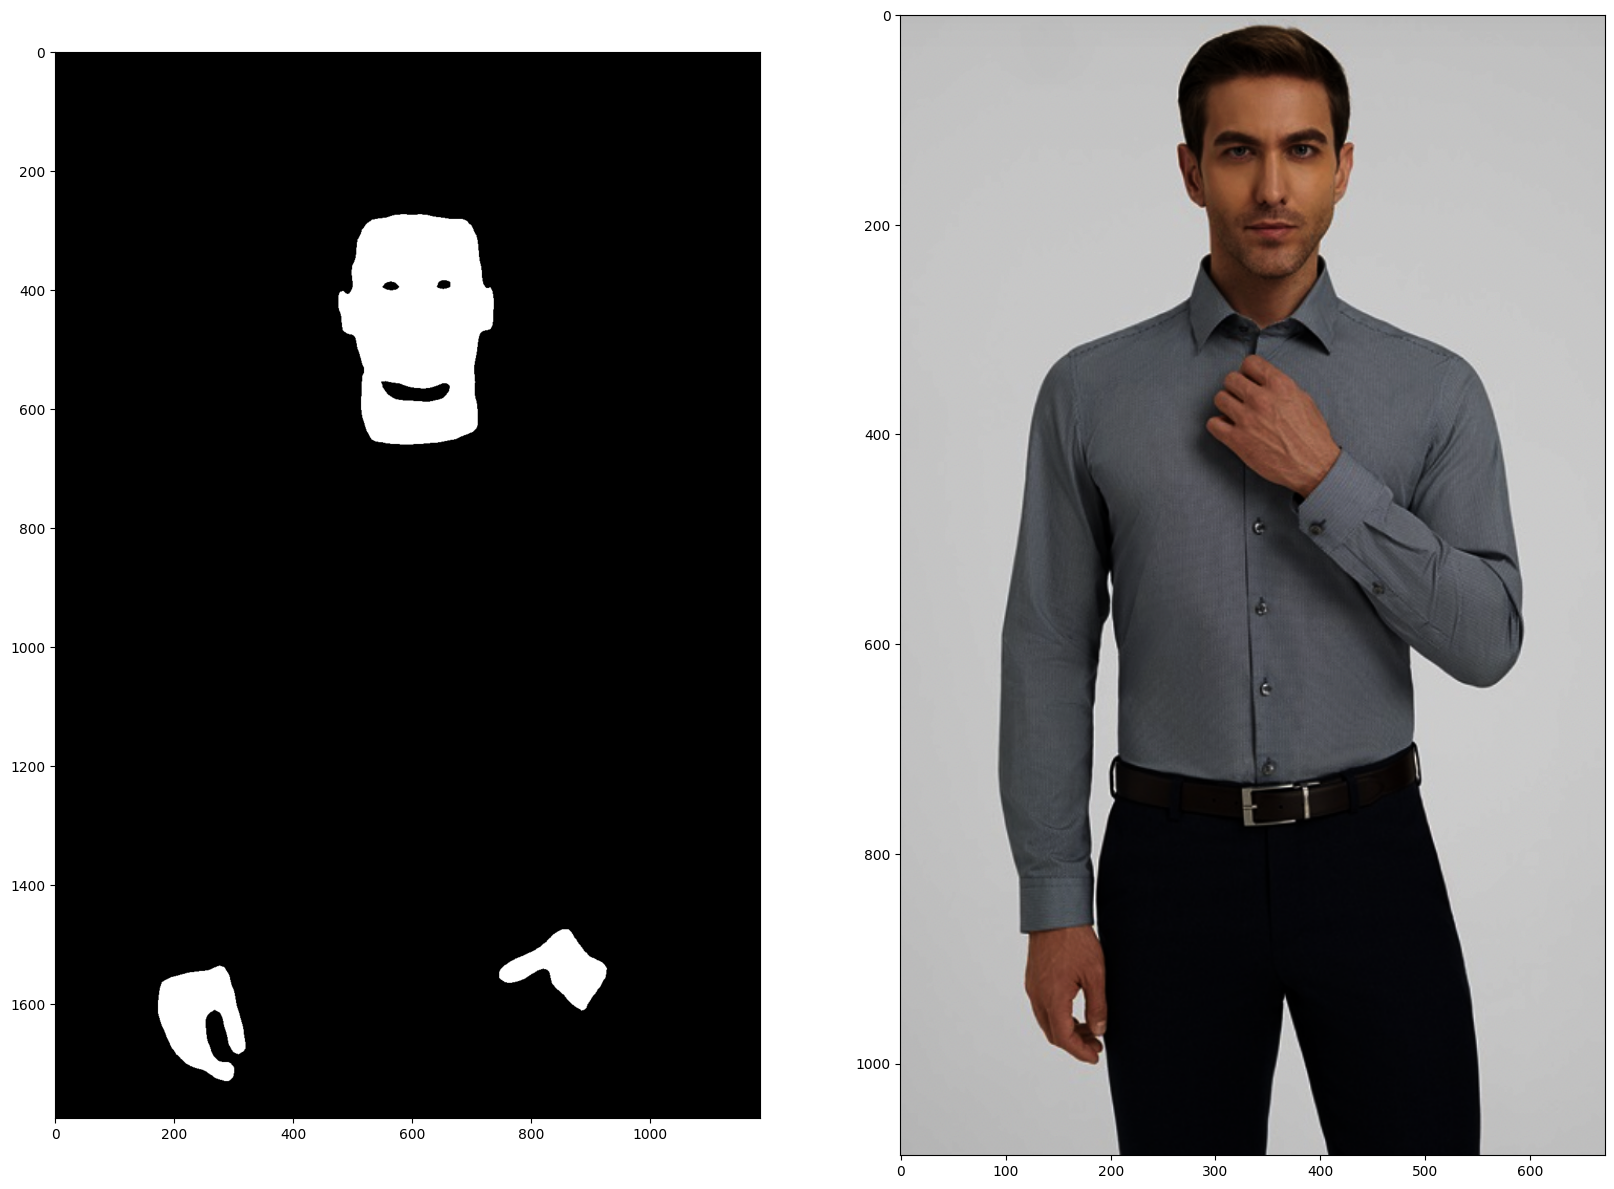

In [218]:
gray = cv2.cvtColor(resized_target, cv2.COLOR_BGR2GRAY)


f, axarr = plt.subplots(1,2,figsize=(20, 15))
axarr[0].imshow(skin_mask_source , cmap='gray')
axarr[1].imshow(resized_target)


REINHARDS COLOR TRANSFER 

In [389]:
# Assuming you have loaded the source and target images (source_image, target_image)
# obtaining the images without gamma correction
_,sourcewm = create_skin_mask(model,source_image)
_,targetwm = create_skin_mask(model,target_image)
 

In [227]:
target_shape = targetwm.shape[:2]  # Get width and height from target image shape
skin_mask_source = downsample_source(skin_mask_source, target_shape)

In [229]:
skin_mask_source.shape

(1088, 672)

In [391]:
# downsampling the source to the target before the images are trasferred to the lab space color 
target_size = targetwm.shape[:2]
sourcewm = downsample_source(sourcewm, target_size)

In [90]:
# Assuming interpolation method is 'nearest' (recommended for masks)
resized_target_mask = cv2.resize(skin_mask_target, (target_image_lab.shape[1], target_image_lab.shape[0]), interpolation=cv2.INTER_NEAREST)


In [102]:
resized_target_mask.dtype
resized_target_mask = resized_target_mask.astype(bool)
resized_target_mask.dtype



dtype('bool')

EXTRACTING THE SKIN REGION FROM THE ENTIRE IMAGE

In [55]:
def extractSkin(image, segmentation_mask=None):
    # If a segmentation mask is provided, use it
    if segmentation_mask is not None:
        skin = cv2.bitwise_and(image, image, mask=segmentation_mask)
    else:
        # Converting from BGR Color Space to HSV
        img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Defining HSV Thresholds
        lower_threshold = (0, 48, 80)
        upper_threshold = (20, 255, 255)

        # Single Channel mask, denoting the presence of colors in the above threshold
        skinMask = cv2.inRange(img, lower_threshold, upper_threshold)

        # Cleaning up mask using Gaussian Filter
        skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)

        # Extracting skin from the threshold mask
        skin = cv2.bitwise_and(image, image, mask=skinMask)

    # Return the Skin image
    return skin

In [62]:
print(f"size of skin mask is {skin_mask_target.shape}")
print(f"size of source skin is {skin_mask_source.shape}")

size of skin mask is (1088, 672)
size of source skin is (1792, 1184)


In [ ]:
def downsample_source(source_image, target_size):
  """
  Downsamples the source image to the size of the target image.

  Args:
      source_image: The source image as a NumPy array.
      target_size: A tuple representing the desired size (width, height) of the downsampled image.

  Returns:
      The downsampled source image as a NumPy array.
  """
  # Convert target size to a tuple (required for cv2.resize)
  
  target_size = (int(target_image_shape[1]), int(target_image_shape[0]))  

  # Use bilinear interpolation for smoother downsampling
  downsampled_source = cv2.resize(source_image, dsize=target_size, interpolation=cv2.INTER_LINEAR)

  return downsampled_source

# Example usage (assuming you have loaded your source image as 'source_image')
target_image_shape = targetwm.shape[:2]  # Get width and height from target image shape
sourcewm = downsample_source(sourcewm, target_image_shape)


In [203]:
target_shape = targetwm.shape[:2] # Get width and height from target image
source_skin = downsample_source(sourcewm, target_shape)

In [63]:
# downsampling the source skin mask to the size of the target 
masksize = skin_mask_target.shape[:2] 
skin_mask_source = downsample_source(skin_mask_source, masksize)

In [230]:
# Extracting the skin region from the images
target_skin = extractSkin(targetwm, skin_mask_target)
source_skin = extractSkin(sourcewm, skin_mask_source)



In [ ]:
def convertTolab(input):
    # Convert input image to Lab color space
    return cv2.cvtColor(input, cv2.COLOR_BGR2LAB)

In [237]:
cv2.imwrite("target.jpg", cv2.cvtColor(target_skin, cv2.COLOR_BGR2RGB))
cv2.imwrite('source.jpg',cv2.cvtColor(source_skin, cv2.COLOR_BGR2RGB))

True

IMPLEMENTING REINHARD

In [295]:
import cv2
import numpy as np

def CoreProcessing(targetf, sourcef, CrossCovarianceLimit, ReshapingIterations, ShaderVal):
    # Convert the images from the BGR color space to the L-alpha-beta color space
    targetf = convertTolab(targetf)
    sourcef = convertTolab(sourcef)

    # Estimate the mean and standard deviation of color channels
    tmean, tdev = cv2.meanStdDev(targetf)
    smean, sdev = cv2.meanStdDev(sourcef)

    # Split the target and source images into color channels
    Lab = list(cv2.split(targetf))
    sLab = list(cv2.split(sourcef))

    # Standardize the distribution within each channel
    for i in range(3):
        Lab[i] = (Lab[i] - tmean[i]) / tdev[i]
        sLab[i] = (sLab[i] - smean[i]) / sdev[i]

    # Implement first phase of reshaping for the color channels
    # when one or more iteration is specified
    jcount = ReshapingIterations
    while jcount > ceil((ReshapingIterations + 1) / 2):
        Lab[1] = ChannelCondition(Lab[1], sLab[1])
        Lab[2] = ChannelCondition(Lab[2], sLab[2])
        jcount -= 1

    # Implement cross covariance processing
    # (null if CrossCovarianceLimit = 0.0)
    targetf = adjust_covariance(Lab, sLab, CrossCovarianceLimit)
    # Lab = cv2.split(targetf)

    # Implement second phase of reshaping
    # while jcount > 0:
        # Lab[1] = ChannelCondition(Lab[1], sLab[1])
        # Lab[2] = ChannelCondition(Lab[2], sLab[2])
        # jcount -= 1

    # Rescale the previously standardized color channels
    # so that the means and standard deviations now match
    # those of the source image
    Lab[1] = Lab[1] * sdev[1] + smean[1]
    Lab[2] = Lab[2] * sdev[2] + smean[2]

    # Rescale the lightness channel (channel 0)
    # in accordance with the specified percentage
    # shading shift
    Lab[0] = Lab[0] * (ShaderVal * sdev[0] + (1.0 - ShaderVal) * tdev[0]) \
             + ShaderVal * smean[0] + (1.0 - ShaderVal) * tmean[0]

    # Merge channels and convert back to BGR color space
    resultant = cv2.merge(Lab)
    resultant = convertFromlab(resultant)

    return resultant


In [412]:
def ChannelCondition(Chan, sChan):
    # Computations use weighted data values
    # 'wval' is the tuning constant for the
    # weighting function
    wval = 0.1

    # Processing for upper 'sChan'
    mask = np.uint8(sChan > 0)
    WU = (1 - np.exp(-wval * sChan / np.mean(sChan)))**2
    ChanU = np.power(sChan, 4) * WU / np.mean(WU)
    
    # Processing for lower 'sChan'
    WL = (1 - np.exp(-wval * sChan / np.mean(sChan)))**2
    ChanL = np.power(sChan, 4) * WL / np.mean(WL)

    # Processing for upper 'Chan'
    mask = np.uint8(Chan > 0)
    WU = (1 - np.exp(-wval * Chan / np.mean(Chan)))**2
    ChanU = np.power(Chan, 4) * WU / np.mean(WU)

    # Processing for lower 'Chan'
    WL = (1 - np.exp(-wval * Chan / np.mean(Chan)))**2
    ChanL = np.power(Chan, 4) * WL / np.mean(WL)

    # Modify the upper 'Chan' values
    k = np.sqrt(np.sqrt(np.mean(sChan) / np.mean(Chan)))
    ChanU = (1 + WU * (k - 1)) * Chan

    # Similarly modify the lower 'Chan' values
    k = np.sqrt(np.sqrt(np.mean(sChan) / np.mean(Chan)))
    ChanL = (1 + WL * (k - 1)) * Chan

    # Combine the upper and lower 'Chan' values
    Chan = np.zeros_like(Chan)
    Chan[mask] = ChanU[mask]
    Chan[~mask] = ChanL[~mask]

    # Re-standardize the modified 'Chan' data
    tmean, tdev = cv2.meanStdDev(Chan)
    Chan = (Chan - tmean[0]) / tdev[0]
    tmean, tdev = cv2.meanStdDev(Chan)

    return Chan


In [184]:

def SaturationProcessing(targetf, savedtf, SatVal):
    # Implement a saturation change unless 100% saturation
    # is specified.
    if SatVal != 1:
        Hsv = cv2.cvtColor(targetf, cv2.COLOR_BGR2HSV)
        temp = cv2.cvtColor(savedtf, cv2.COLOR_BGR2HSV)
        Hsv[1] = Hsv[1] * SatVal + temp[1] * (1 - SatVal)
        
        # Compute a weighted mix of the processed target
        # saturation channel and the original image
        # saturation channel to define an initial
        # reference saturation channel.
        initial_ref_sat = np.where(Hsv[1] > temp[1], Hsv[1], temp[1])
        
        # Compute the mean and standard deviation of the
        # saturation channel for the processed image channel
        # to the mean and standard deviation of the modified
        # reference saturation channel.
        tmean, tdev = cv2.meanStdDev(Hsv[1])
        tmpmean, tmpdev = cv2.meanStdDev(initial_ref_sat)
        Hsv[1] = (Hsv[1] - tmean[0]) / tdev[0]
        Hsv[1] = Hsv[1] * tmpdev[0] + tmpmean[0]
        
        targetf = cv2.cvtColor(Hsv, cv2.COLOR_HSV2BGR)

    return targetf


In [273]:

def FullShading(targetf, savedtf, sourcef, ExtraShading, ShaderVal):
    if ExtraShading:
        greyt = cv2.cvtColor(savedtf, cv2.COLOR_BGR2GRAY)
        greyp = cv2.cvtColor(targetf, cv2.COLOR_BGR2GRAY)
        greys = cv2.cvtColor(sourcef, cv2.COLOR_BGR2GRAY)

        # Standardise the grey shade images for the source and target.
        smean, sdev = cv2.meanStdDev(greys)
        tmean, tdev = cv2.meanStdDev(greyp)
        greyt = (greyt - tmean[0]) / tdev[0]

        # Rescale the previously standardised grey shade target image
        greyt = greyt * (ShaderVal * sdev[0] + (1.0 - ShaderVal) * tdev[0]) + ShaderVal * smean[0] + (1.0 - ShaderVal) * tmean[0]

        # Rescale each of the colour channels of the processed image identically
        # so that in grey shade the processed image more closely matches
        # the grey shading of the nominated goal image.
        greyp = np.maximum(greyp, 1 / 255.0)  # Guard against zero divide
        greyt = np.maximum(greyt, 0.0)  # Guard against negative values

        chans = list(cv2.split(targetf))
        for i in range(len(chans)):
            chans[i] = chans[i] / greyp * greyt

        targetf = cv2.merge(chans)

    return targetf


In [186]:

def FinalAdjustment(targetf, savedtf, TintVal, ModifiedVal):
    # If 100% tint not specified then compute a weighted average
    # of the processed image and its grayscale representation.
    if TintVal != 1.0:
        grey = cv2.cvtColor(targetf, cv2.COLOR_BGR2GRAY)
        BGR = cv2.split(targetf)
        for i in range(3):
            BGR[i] = TintVal * BGR[i] + (1.0 - TintVal) * grey
        targetf = cv2.merge(BGR)

    # If 100% image modification not specified then
    # compute a weighted average of the processed image
    # and the original target image.
    if ModifiedVal != 1.0:
        targetf = ModifiedVal * targetf + (1.0 - ModifiedVal) * savedtf

    return targetf


In [187]:
# Define transformation matrices
RGB_to_LMS = np.array([[0.3811, 0.5783, 0.0402],
                       [0.1967, 0.7244, 0.0782],
                       [0.0241, 0.1288, 0.8444]], dtype=np.float32)

LMS_to_lab = np.array([[1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)],
                       [1/np.sqrt(6), 1/np.sqrt(6), -2/np.sqrt(6)],
                       [1/np.sqrt(2), -1/np.sqrt(2), 0]], dtype=np.float32)

def convertTolab(input):
    # Convert input image to float and swap channel order
    img_RGBf = cv2.cvtColor(input, cv2.COLOR_BGR2RGB).astype(np.float32)

    # Apply stage 1 transform
    img_lms = np.dot(img_RGBf, RGB_to_LMS.T)

    # Define smallest permitted value and implement it
    epsilon = 1.0 / 255
    img_lms = np.maximum(img_lms, epsilon)

    # Compute log10(x) as ln(x)/ln(10)
    img_lms = np.log10(img_lms)

    # Apply stage 2 transform
    img_lab = np.dot(img_lms, LMS_to_lab.T)

    return img_lab


def convertFromlab(input):
    # Apply inverse of stage 2 transformation
    img_lms = np.dot(input, np.linalg.inv(LMS_to_lab).T)

    # Compute 10^x as (e^x)^(ln10)
    img_lms = np.exp(img_lms)
    img_lms = np.power(img_lms, np.log(10))

    # Apply inverse of stage 1 transformation
    img_RGBf = np.dot(img_lms, np.linalg.inv(RGB_to_LMS).T)

    # Revert channel ordering to BGR
    img_BGRf = cv2.cvtColor(img_RGBf.astype(np.float32), cv2.COLOR_RGB2BGR)

    return img_BGRf


In [418]:
import cv2
import numpy as np

def main():
    # PROCESSING OPTIONS
    CrossCovarianceLimit = 0.0 # Option 1 (Default is '0.5')
    ReshapingIterations = 1      # Option 2 (Default is '1')
    PercentSaturationShift = 2.0  # Option 3 (Default is -1.0)
    PercentShadingShift = 50.0     # Option 4 (Default is 50.0)
    ExtraShading = True            # Option 5 (Default is 'true')
    PercentTint = 100.0            # Option 6 (Default is 100.0)
    PercentModified = 100.0        # Option 7 (Default is 100.0)

    # Specify the image files that are to be processed
    targetname = "source.jpg"
    sourcename =  "target.jpg"

    # Read in the images and convert to floating point,
    # saving a copy of the target image for later.
    target = cv2.imread(targetname, 1)
    source = cv2.imread(sourcename, 1)

    targetf = target.astype(np.float32) / 255.0
    sourcef = source.astype(np.float32) / 255.0
    savedtf = targetf.copy()

    # Implement augmented "Reinhard Processing" in
    # L-alpha-beta colour space.
    targetf = CoreProcessing(targetf, sourcef, CrossCovarianceLimit,
                             ReshapingIterations,
                             PercentShadingShift / 100.0)
    #sourcef = cv2.cvtColor(sourcef, cv2.COLOR_BGR2GRAY)  # Only need mono hereafter.

    # Implement image refinements where a change is specified.
    targetf = SaturationProcessing(targetf, savedtf,
                                   PercentSaturationShift / 100.0)
    targetf = FullShading(targetf, savedtf, sourcef, ExtraShading,
                          PercentShadingShift / 100.0)
    targetf = FinalAdjustment(targetf, savedtf,
                              PercentTint / 100.0,
                              PercentModified / 100.0)

    # Convert the processed image to integer format.
    result = (targetf * 255.0).astype(np.uint8)

    # Display and save the final image.
    cv2.imshow("processed image", result)
    processedimage = result
    cv2.imwrite("processed.jpg", result)

    # Display image until a key is pressed.
    cv2.waitKey(0)


if __name__ == "__main__":
    main()



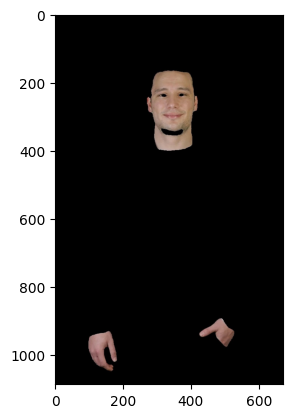

In [419]:
processed = 'processed.jpg'
processed_skin = cv2.imread(processed)
processed_skin = cv2.cvtColor(processed_skin, cv2.COLOR_BGR2RGB)
plt.imshow(processed_skin)

In [314]:
print(f"shape of processed image is {processed_skin.shape}")
print(f"shape of source image{sourcewm.shape}")
print(f"shape of mask{skin_mask_source.shape}")

      

shape of processed image is (1088, 672, 3)
shape of source image(1088, 672, 3)
shape of mask(1088, 672)


IMPLEMENTING BLENDING WITH POISSONS

In [ ]:
# Poissons image editing focuses on copying image gradients instead of copying pixel intensities
# In this algorithm , you find the gradient of the target and replace it in the source image
# The boundary pixels in the source image should also be the same as the boundary pixels in the target image
# Poissons equation is used for these estimations.


In [368]:
# Finding the center of the image
#moments = cv2.moments(skin_mask_source)
#center = (int(moments['m10']/moments['m00']), int(moments['m01']/moments['m00']))
 
# Seamlessly clone src into dst and put the results in output
#normal_clone = cv2.seamlessClone(sourcewm,processed_skin, skin_mask_source, center, cv2.NORMAL_CLONE)

 

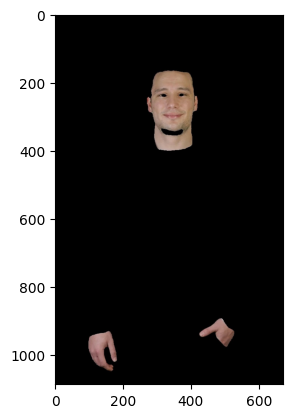

In [402]:
plt.imshow(processed_skin)

In [421]:


# Replace the skin region in the original image with the processed skin region
sourcewmm = sourcewm.copy()


sourcewmm[skin_mask_source > 0] = processed_skin[skin_mask_source > 0]
sourcewmm = cv2.cvtColor(sourcewmm, cv2.COLOR_BGR2RGB)
result = sourcewmm
#sourcewm = cv2.cvtColor(sourcewm, cv2.COLOR_BGR2RGB)

# Display or save the resulting image
cv2.imshow("Result Image", sourcewmm)
cv2.waitKey(0)
cv2.destroyAllWindows()


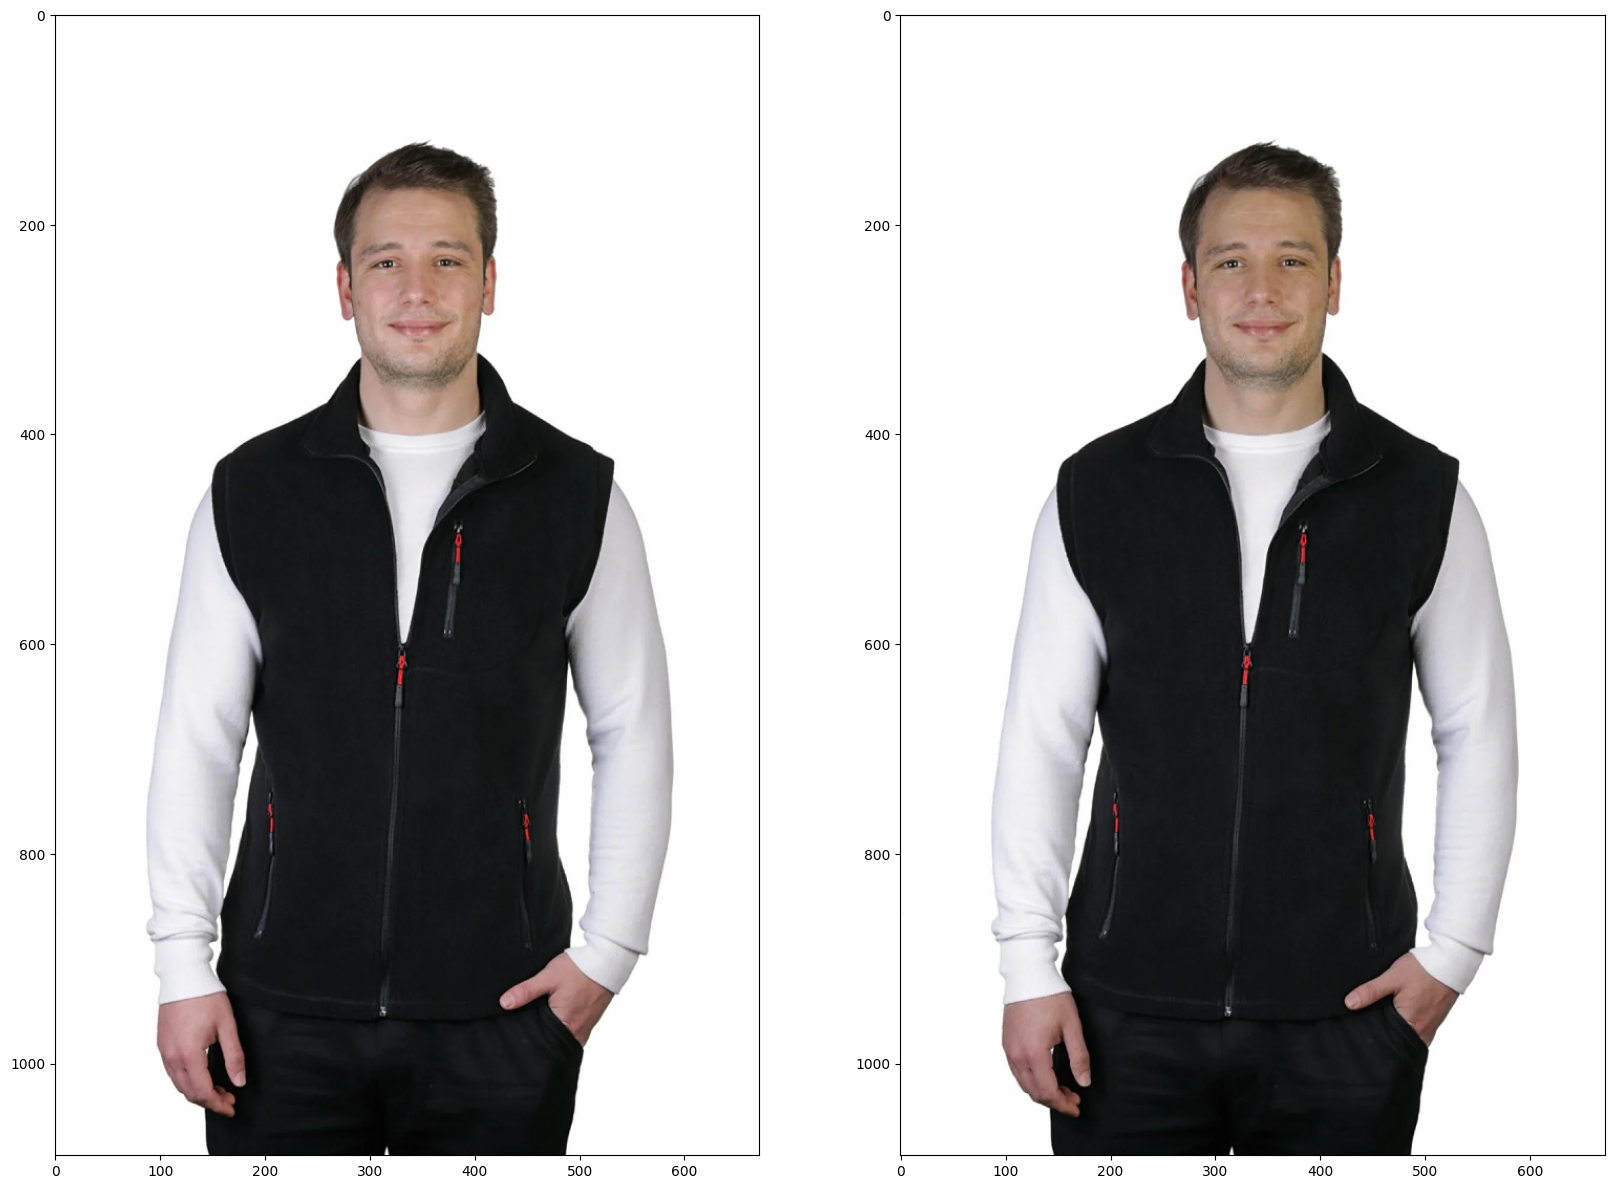

In [422]:
f, axarr = plt.subplots(1,2,figsize=(20, 15))
axarr[0].imshow(sourcewm)
axarr[1].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

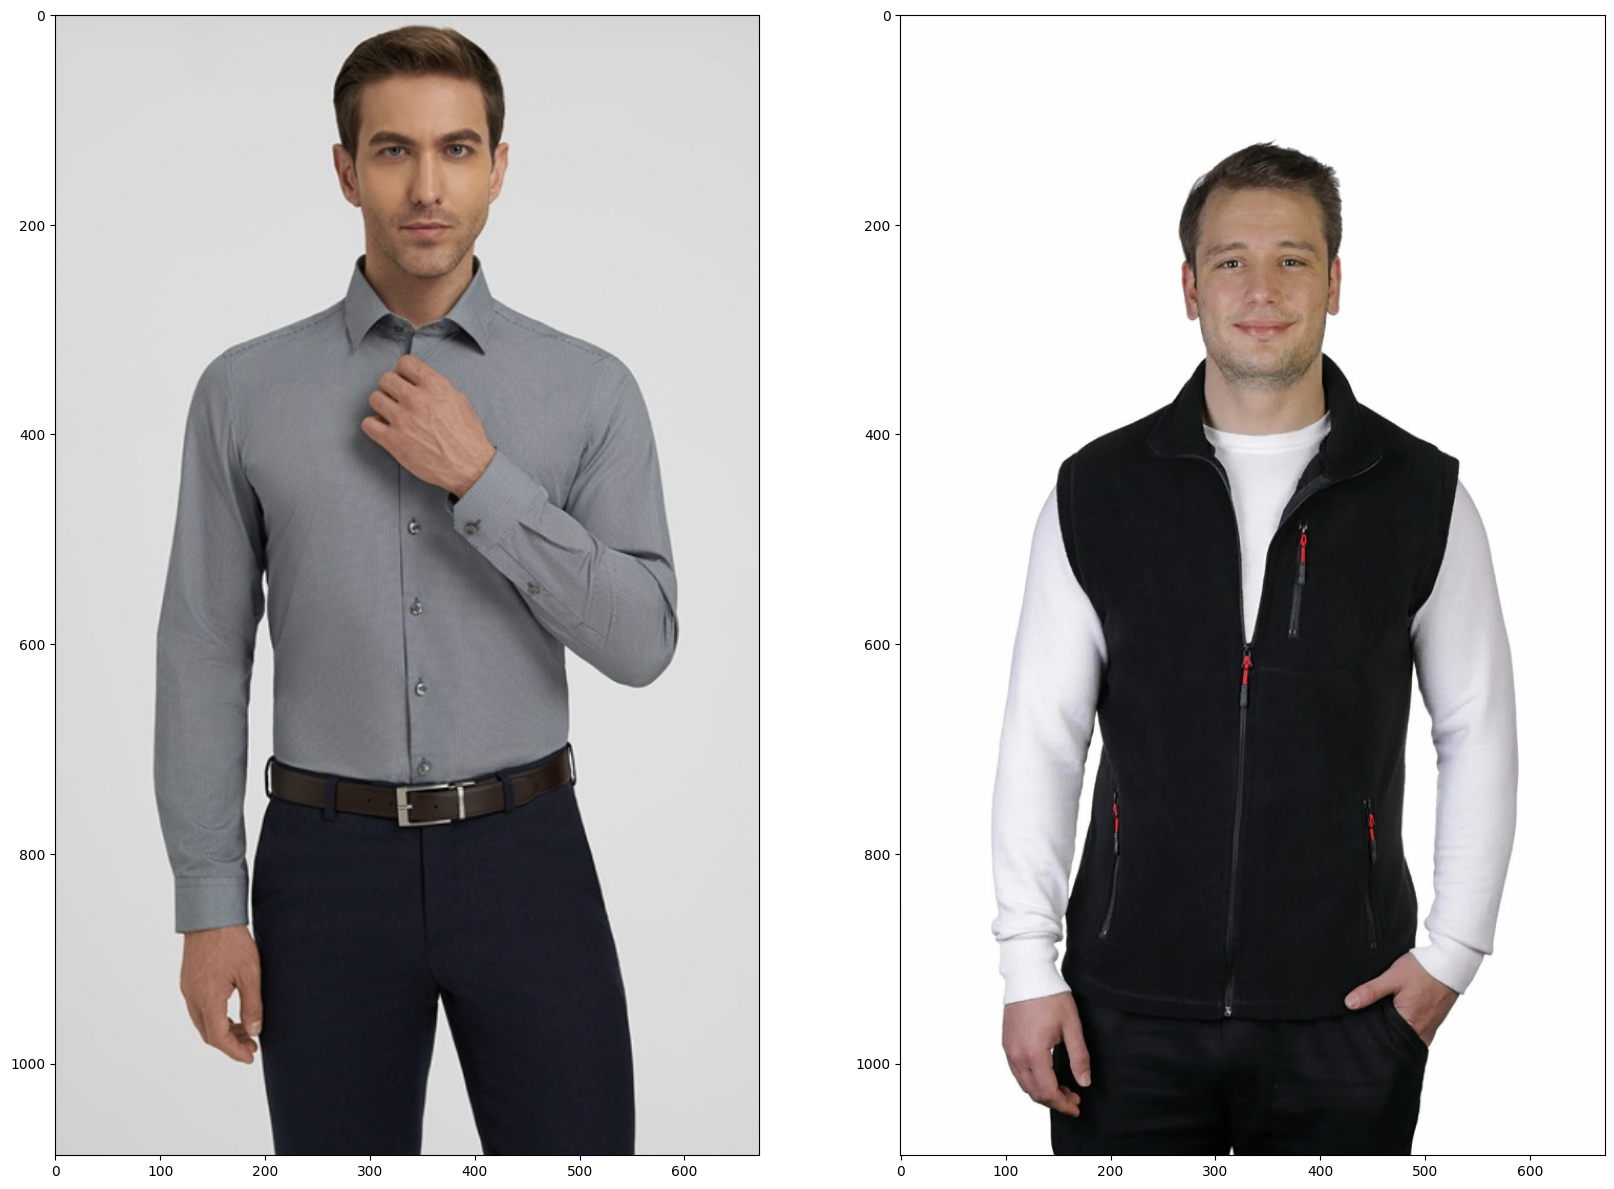

In [423]:
f, axarr = plt.subplots(1,2,figsize=(20, 15))
axarr[0].imshow(targetwm)
axarr[1].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))